<a href="https://colab.research.google.com/github/TsabitaNurul/TugasPraktikumML_058-082/blob/main/Augmentasi_CNN_Model(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Definisikan path kaggle json
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/PMesin"

In [6]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/MyDrive/PMesin

/content/drive/MyDrive/PMesin


In [7]:
!ls

 cell_images   dataset	'kaggle (1).json'   kaggle.json   test	 train	 valid


In [24]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 672M/675M [00:07<00:00, 109MB/s]
100% 675M/675M [00:08<00:00, 88.0MB/s]


In [25]:
# Cek isi direktori kerja dan memastikan dataset telah berhasil didownload.
!ls

 cell-images-for-detecting-malaria.zip	'kaggle (1).json'   kaggle.json


In [26]:
# Ekstrak file dataset dan hapus file zip dataset agar tidak memakan banyak tempat.
!unzip \*.zip &> /dev/null && rm *.zip

In [27]:
!ls

 cell_images  'kaggle (1).json'   kaggle.json


In [28]:
from os import mkdir

mkdir('dataset')

In [15]:
ls

 cell_images/   dataset/  'kaggle (1).json'   kaggle.json


In [29]:
import shutil, sys

shutil.move("/content/drive/MyDrive/PMesin/cell_images/Parasitized", "/content/drive/My Drive/PMesin/dataset") 
shutil.move("/content/drive/MyDrive/PMesin/cell_images/Uninfected", "/content/drive/My Drive/PMesin/dataset") 

'/content/drive/My Drive/PMesin/dataset/Uninfected'

In [30]:
import numpy as np
import pandas as pd
import os
from shutil import copyfile

TRAIN_DIR = "/content/drive/My Drive/PMesin/train/"
VALID_DIR ="/content/drive/My Drive/PMesin/valid/"
TEST_DIR ="/content/drive/My Drive/PMesin/test/"

os.mkdir(TRAIN_DIR)
os.mkdir(VALID_DIR)
os.mkdir(TEST_DIR)

for label in ['Uninfected', 'Parasitized']:
    os.mkdir(TRAIN_DIR+label)
    os.mkdir(VALID_DIR+label)
    os.mkdir(TEST_DIR+label)

In [31]:
import random

def train_valid_test_split(source, train_dir, valid_dir, test_dir,train_size, valid_size, test_size):
    # get files
    files = []
    for filename in os.listdir(source):
        file = source + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
    
    # train valid split
    train_size = int(len(files) * (1-(valid_size + train_size)))
    valid_size = int(len(files) * (1-(valid_size + test_size)))
    test_size = int(len(files) * (1-train_size))
  
    # shuffle the dataset
    shuffled_files = random.sample(files, len(files))
    
    train_set = shuffled_files[train_size:valid_size]
    valid_set = shuffled_files[valid_size:]
    test_set = shuffled_files[:train_size]
    
    for filename in train_set:
        filepath = source + filename
        destination = train_dir + filename
        copyfile(filepath, destination)
        
    for filename in valid_set:
        filepath = source + filename
        destination = valid_dir + filename
        copyfile(filepath, destination)
    
    for filename in test_set:
        filepath = source + filename
        destination = test_dir + filename
        copyfile(filepath, destination)

SOURCE = "/content/drive/MyDrive/PMesin/dataset/"

for label in ['Uninfected', 'Parasitized']:
    print(label)
    train_valid_test_split(SOURCE+label+'/', TRAIN_DIR +label+'/', VALID_DIR +label+'/', TEST_DIR +label+'/', train_size=0.8, valid_size=0.19, test_size=0.01)
    print(len(os.listdir(TRAIN_DIR +label+'/')))
    print(len(os.listdir(VALID_DIR +label+'/')))
    print(len(os.listdir(TEST_DIR +label+'/')))

Uninfected
10887
2756
137
Parasitized
10887
2756
137


In [32]:
from keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    vertical_flip = True,
    rotation_range = 90,
    height_shift_range = 0.2,
    width_shift_range = 0.2,
    zoom_range = 0.2
)

test_generator = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.7
)

In [33]:
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
val_images = test_generator.flow_from_directory(
    VALID_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
    subset = 'training'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(100, 100),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42,
    subset = 'validation'
)

Found 21772 images belonging to 2 classes.
Found 1654 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [34]:
# TULIS KODE ANDA DISINI
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, AveragePooling2D, Flatten, BatchNormalization, Dropout
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
    tf.keras.layers.AveragePooling2D(2, 2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(2, activation='softmax')
])

In [35]:
# Print model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 98, 98, 16)        448       
                                                                 
 average_pooling2d (AverageP  (None, 49, 49, 16)       0         
 ooling2D)                                                       
                                                                 
 dropout (Dropout)           (None, 49, 49, 16)        0         
                                                                 
 batch_normalization (BatchN  (None, 49, 49, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 47, 47, 16)        2320      
                                                                 
 average_pooling2d_1 (Averag  (None, 23, 23, 16)       0

In [36]:
# Compile model
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(lr=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [37]:
history = model.fit(
    train_images,
    validation_data = val_images,
    epochs = 100,
    callbacks = [
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=40,
            verbose=1, 
            mode='auto',
            cooldown=1
        )
    ]
)

Epoch 1/100
681/681 [==============================] - 159s 188ms/step - loss: 0.8332 - accuracy: 0.5755 - val_loss: 0.6516 - val_accuracy: 0.6542 - lr: 1.0000e-04
Epoch 2/100
681/681 [==============================] - 124s 182ms/step - loss: 0.7112 - accuracy: 0.6130 - val_loss: 0.6090 - val_accuracy: 0.6989 - lr: 1.0000e-04
Epoch 3/100
681/681 [==============================] - 122s 179ms/step - loss: 0.6645 - accuracy: 0.6422 - val_loss: 0.5390 - val_accuracy: 0.7316 - lr: 1.0000e-04
Epoch 4/100
681/681 [==============================] - 122s 179ms/step - loss: 0.6152 - accuracy: 0.6811 - val_loss: 0.5202 - val_accuracy: 0.7310 - lr: 1.0000e-04
Epoch 5/100
681/681 [==============================] - 124s 182ms/step - loss: 0.5222 - accuracy: 0.7493 - val_loss: 0.5421 - val_accuracy: 0.7551 - lr: 1.0000e-04
Epoch 6/100
681/681 [==============================] - 122s 180ms/step - loss: 0.4551 - accuracy: 0.7963 - val_loss: 0.5798 - val_accuracy: 0.7751 - lr: 1.0000e-04
Epoch 7/100
681/

In [38]:
import matplotlib.pyplot as plt
def eval_plot(history):

  plt.figure(figsize=(14, 5))

  # Accuracy plot
  plt.subplot(1, 2, 1)
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  epochs = range(len(acc))
  acc_plot, = plt.plot(epochs, acc, 'r')
  val_acc_plot, = plt.plot(epochs, val_acc, 'b')
  plt.title('Training and Validation Accuracy')
  plt.legend([acc_plot, val_acc_plot], ['Training Accuracy', 'Validation Accuracy'])

  # Loss plot
  plt.subplot(1, 2, 2)
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(loss))
  loss_plot, = plt.plot(epochs, loss, 'r')
  val_loss_plot, = plt.plot(epochs, val_loss, 'b')
  plt.title('Training and Validation Loss')
  plt.legend([loss_plot, val_loss_plot], ['Training Loss', 'Validation Loss'])

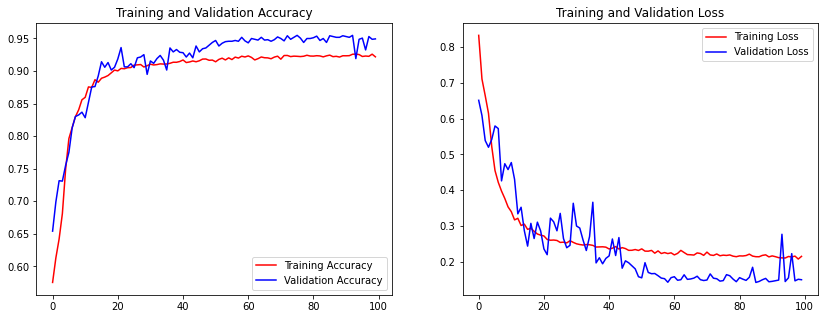

In [39]:
eval_plot(history)

In [40]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def evaluate(model):

  valid_generator = train_generator.flow_from_directory(
          TRAIN_DIR, 
          target_size=(100,100), 
          batch_size=32, 
          class_mode='categorical',
          shuffle = False)

  batch_size = 32
  num_of_test_samples = len(valid_generator.filenames)

  Y_pred = model.predict_generator(valid_generator, num_of_test_samples // batch_size+1)
  y_pred = np.argmax(Y_pred, axis=1)

  print('\nConfusion Matrix\n')
  cm = confusion_matrix(valid_generator.classes, y_pred)
  plt.figure(figsize=(8, 8))
  sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='Blues', cbar=False)
  plt.xticks(ticks=[0.5, 1.5], labels=['Uninfected', 'Paracitized'])
  plt.yticks(ticks=[0.5, 1.5], labels=['Uninfected', 'Paracitized'])
  plt.xlabel("Predicted")
  plt.ylabel("Actual")
  plt.title("Confusion Matrix")
  plt.show()

  print('\n\nClassification Report\n')
  target_names = ['Uninfected', 'Paracitized']
  print(classification_report(valid_generator.classes, y_pred, target_names=target_names))

Found 21772 images belonging to 2 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  app.launch_new_instance()



Confusion Matrix



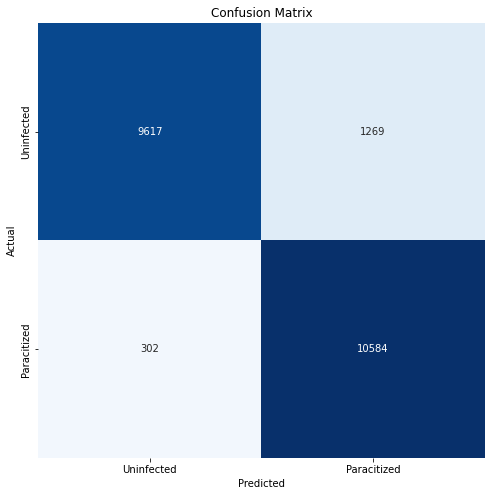



Classification Report

              precision    recall  f1-score   support

  Uninfected       0.97      0.88      0.92     10886
 Paracitized       0.89      0.97      0.93     10886

    accuracy                           0.93     21772
   macro avg       0.93      0.93      0.93     21772
weighted avg       0.93      0.93      0.93     21772



In [41]:
evaluate(model)

In [42]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file: json_file.write(model_json)

In [43]:
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk
